# Import Libraries

In [1]:
# import os
import numpy as np
import pandas as pd

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

In [3]:
from features.mfcc_feature_extraction import mfcc_feature_extraction
from utils.visualisation import augmented_lables_count, plot_loss_curves, confusion_matrix_classes
from features.class_labels_encoding import encode_labels_to_categorical
from models.prepare_train_test_data import prepare_test_train_data
from models.model_design_and_training import create_model, train_model
from sklearn.metrics import classification_report
import bentoml

# Load Dataset

In [4]:
# Location of Data Folder:
data_folder = '../../data/Respiratory_Sound_Data'

In [5]:
# Lung Audio Data Folder:
audio_data_folder = f'{data_folder}/audio_and_txt_files/'

In [6]:
# Test Audio Files:
audio1 = f'{audio_data_folder}104_1b1_Lr_sc_Litt3200.wav'
audio2 = f'{audio_data_folder}224_1b1_Tc_sc_Meditron.wav'
audio3 = f'{audio_data_folder}108_1b1_Al_sc_Meditron.wav'
audio4 = f'{audio_data_folder}182_1b1_Tc_sc_Meditron.wav'
audio5 = f'{audio_data_folder}223_1b1_Al_sc_Meditron.wav'
audio6 = f'{audio_data_folder}226_1b1_Pl_sc_LittC2SE.wav'


In [7]:
diagnosis_df = pd.read_csv('../../notebooks/patient_diagnosis_relabelled.csv')

In [8]:
diagnosis_df

,pid,diagnosis
0,101,Acute
1,102,Healthy
2,103,Chronic
3,104,Chronic
4,105,Acute
...,...,...
121,222,Chronic
122,223,Chronic
123,224,Healthy
124,225,Healthy


# Data Preprocessing

In [9]:
x_mfccs, y = mfcc_feature_extraction(dir_=audio_data_folder,diagnosis_df=diagnosis_df)

Processing 920 audio files...
Processed 50/920 files...
Processed 100/920 files...
Processed 150/920 files...
Processed 200/920 files...
Processed 250/920 files...
Processed 300/920 files...
Processed 350/920 files...
Processed 400/920 files...
Processed 450/920 files...
Processed 500/920 files...
Processed 550/920 files...
Processed 600/920 files...
Processed 650/920 files...
Processed 700/920 files...
Processed 750/920 files...
Processed 800/920 files...
Processed 850/920 files...
Processed 900/920 files...

Feature extraction completed!
Final dataset shape: (997, 52)
Label distribution: {np.str_('Acute'): np.int64(450), np.str_('Chronic'): np.int64(337), np.str_('Healthy'): np.int64(210)}


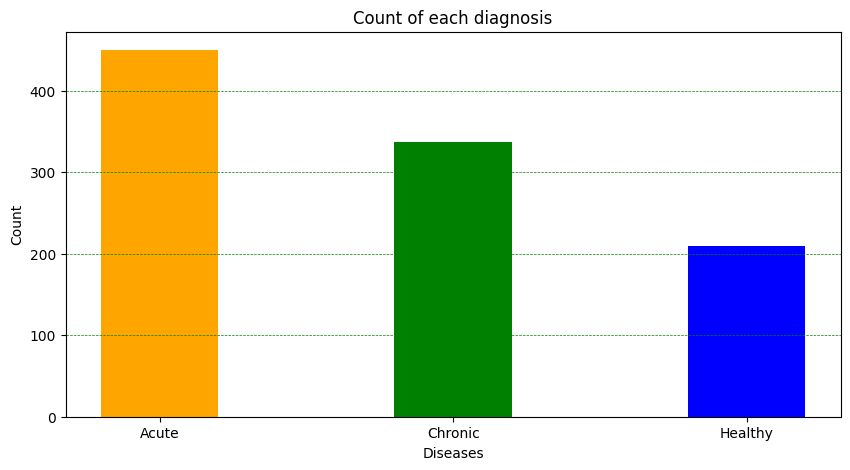

{np.str_('Acute'): np.int64(450), np.str_('Chronic'): np.int64(337), np.str_('Healthy'): np.int64(210)}


In [10]:
augmented_lables_count(y)

In [11]:
Y_data = encode_labels_to_categorical(y=y)

In [12]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((997, 52), (997, 3))

In [13]:
# Assume mfccs_features and labels are already defined

(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_test_train_data(mfccs_features, lables)

print("Training shapes:", x_train.shape, y_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape)
print("Test shapes:", x_test.shape, y_test.shape)

Training shapes: (697, 1, 52) (697, 1, 3)
Validation shapes: (200, 1, 52) (200, 1, 3)
Test shapes: (100, 1, 52) (100, 1, 3)


# Model Development

In [14]:
deeprespnet_model = create_model()

In [15]:
deeprespnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
deeprespnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 52)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 256)    │     66,816 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 256)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 256)    │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 512)    │    655,872 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 512)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 512)    │      2,048 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1, 32)     │     52,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 1, 128)    │     74,496 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 1, 128)    │     62,208 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 1, 128)    │     74,496 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 128)    │          0 │ gru_3[0][0],      │
│                     │                   │            │ gru_1[0][0],      │
│                     │                   │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 1, 128)    │     99,072 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 1, 64)     │     37,248 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 1, 32)     │     15,552 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 1, 32)     │      9,408 │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 32)     │          0 │ gru_7[0][0],      │
│                     │                   │            │ gru_9[0][0],      │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 32)     │      1,056 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,398,755 (5.34 MB)

 Trainable params: 1,397,219 (5.33 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Train Model

In [17]:
history = train_model(deeprespnet_model,x_train,y_train,x_val,y_val)

Epoch 1/5
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3997 - loss: 1.0515
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to ./models/saved_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.4152 - loss: 1.0425 - val_accuracy: 0.4500 - val_loss: 1.0525
Epoch 2/5
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6456 - loss: 0.8260
Epoch 2: val_accuracy improved from 0.45000 to 0.46000, saving model to ./models/saved_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6450 - loss: 0.8234 - val_accuracy: 0.4600 - val_loss: 1.0299
Epoch 3/5
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7004 - loss: 0.7071
Epoch 3: val_accuracy improved from 0.46000 to 0.58500, saving model to ./models/saved_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6958 - loss: 0.7067 - val_accuracy: 0.5850 - val_loss: 0.9371
Epoch 4/5
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7464 - loss: 0.6136
Epoch 4: val_accuracy 

## Model Evaluation

In [18]:
train_loss, train_accuracy = deeprespnet_model.evaluate(x_train, y_train)
print(f"Train Accuracy: {train_accuracy} \nTrain Loss: {train_loss}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6594 - loss: 0.7897
Train Accuracy: 0.6786226630210876 
Train Loss: 0.7746893167495728


In [31]:
val_loss, val_accuracy = deeprespnet_model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {val_accuracy} \nValidation Loss: {val_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7100 - loss: 0.7636 
Validation Accuracy: 0.7049999833106995 
Validation Loss: 0.7619580030441284


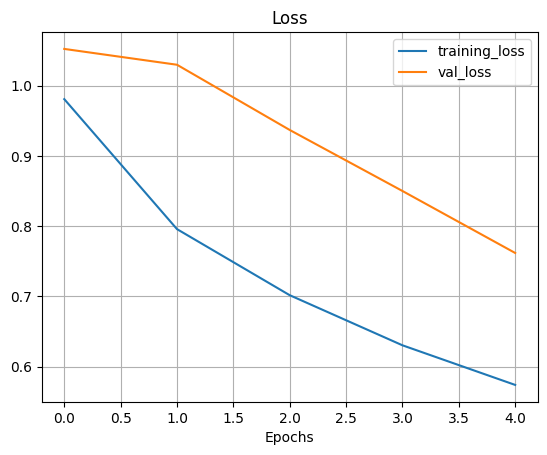

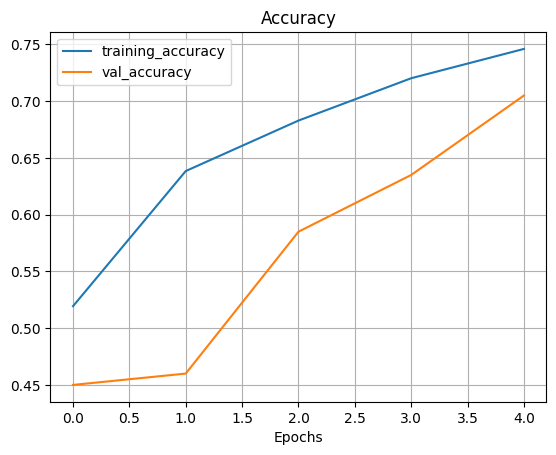

In [20]:
plot_loss_curves(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step


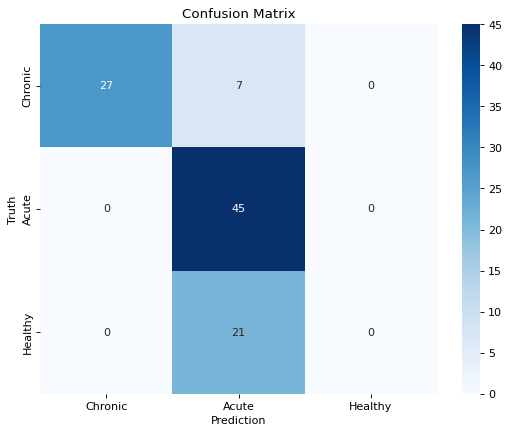

In [21]:
y_testclass, classpreds = confusion_matrix_classes(deeprespnet_model,x_test,y_test)

In [22]:
print(classification_report(y_testclass, classpreds, target_names=['Chronic', 'Acute', 'Healthy']))

              precision    recall  f1-score   support

     Chronic       1.00      0.79      0.89        34
       Acute       0.62      1.00      0.76        45
     Healthy       0.00      0.00      0.00        21

    accuracy                           0.72       100
   macro avg       0.54      0.60      0.55       100
weighted avg       0.62      0.72      0.64       100



/DeepRespNet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/DeepRespNet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/DeepRespNet/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [23]:
result = deeprespnet_model.evaluate(x_train, y_train)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6594 - loss: 0.7897


In [24]:
type(result)

list

# Saving the model

In [25]:
# Save the model to BentoML model store
saved_model = bentoml.keras.save_model(
    name="lung_sound_classifier",  # This will be the model name/tag
    model=deeprespnet_model,  # Use the correct variable name
    metadata={
        "epochs": "5",
        "model_type": "CNN-GRU",
        "input_shape": "(1, 52)",
        "classes": ["Acute", "Chronic", "Healthy"],
        "train_accuracy": f"{train_accuracy:.4f}",
        "val_accuracy": f"{val_accuracy:.4f}",
        "framework": "tensorflow-keras"
    },
    labels={
        "team": "ml",
        "stage": "development",
        "task": "audio_classification"
    }
)

print(f"Model saved successfully: {saved_model.tag}")
print(f"Model path: {saved_model.path}")

/DeepRespNet/.venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/tmp/ipykernel_79629/1754951658.py:2: BentoMLDeprecationWarning: `bentoml.keras` is deprecated since v1.4 and will be removed in a future version.
  saved_model = bentoml.keras.save_model(


Model saved successfully: lung_sound_classifier:f6wkfuc6gokal33a
Model path: /root/bentoml/models/lung_sound_classifier/f6wkfuc6gokal33a/


In [26]:
# deeprespnet_model.save("./diagnosis_model8.h5")

In [27]:
# deeprespnet_model.save("../models/deeprespnet_model.keras")

In [28]:
# from keras.models import load_model
# # Step 2: Load it back (as required by BentoML)
# loaded_model = load_model("../models/deeprespnet_model.keras", compile=False)

In [29]:
# bentoml.keras.save_model(
#         "lung_sound_classifier",
#         loaded_model,
#          metadata={
#             "epochs": "5",
#             "model_type": "CNN-GRU",
#             "input_shape": "(1, 52)",
#             "classes": ["Acute", "Chronic", "Healthy"],
#             "accuracy": "0.70"
#         }
# )

In [39]:
history_path = "./models/training_history.npy"
np.save(history_path, history.history)
print(f"📊 Training history saved to: {history_path}")

📊 Training history saved to: ./models/training_history.npy


# Prediction

In [40]:
from predictions import audio_preprocessing, deeprespnet_diagnosis_prediction

classes = ['Chronic','Acute','Healthy']
features = audio_preprocessing(audio_input=audio1)
predicted_class, confidence = deeprespnet_diagnosis_prediction(features=features,model=deeprespnet_model,use_bento_model=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


In [41]:
print(f"Class : {predicted_class}, Confidence : {confidence}")

Class : Chronic, Confidence : 0.47295287251472473
